In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# from jupyterthemes import jtplot
# jtplot.style()
from segmenter import *
from IPython.core.debugger import set_trace
from fastai.conv_learner import *
torch.cuda.is_available(), torch.backends.cudnn.enabled

/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(True, True)

In [2]:
PATH = Path('/home/sean/hpc-home/skin_cancer/')

%ls $PATH/'dermofit'

AK/      ALLIEC/  ALLSK/    iec.zip*         models/   sk.zip*
ak.zip*  ALLMEL/  ALLVASC/  lesionlist.txt*  PYO/      tmp/
ALLBCC/  ALLML/   bcc.zip*  mel.zip*         pyo.zip*  train.csv*
ALLDF/   ALLSCC/  df.zip*   ml.zip*          scc.zip*  vasc.zip*


In [18]:
xtrn_i = PATH / 'ISIC/ISIC-2017_Training_Data'
ytrn_i = PATH / 'ISIC/ISIC-2017_Training_Part1_GroundTruth'

xtrn_d = PATH / 'dermofit/'

xval_path = PATH / 'ISIC/ISIC-2017_Validation_Data'
yval_path = PATH / 'ISIC/ISIC-2017_Validation_Part1_GroundTruth'

# xtrn_path.exists(), ytrn_path.exists(), xval_path.exists(), ytrn_path.exists()
def get_all_files(p, fl, ext):
    ims = []
    for root, dirs, files in os.walk(p):
        for fn in files:
            if fn.endswith(ext) and fl in fn:
                # The right filetype and the image we want!
                ims.append(os.path.join(root, fn))
    if len(ims) == 0:
        print('No images found')
    return ims

d_files = get_all_files(xtrn_d, '', '.png')
assert all([os.path.isfile(x) for x in d_files]), 'Some invalid files'

xd = np.array(sorted([x for x in d_files if not 'mask' in x]))
yd = np.array(sorted([x for x in d_files if 'mask' in x]))

j='.jpg'
p='.png'

trn_x = np.append(g_fns(xtrn_i, j), xd)
val_x = g_fns(xval_path, j)

trn_y = np.append(g_fns(ytrn_i, p), yd)
val_y = g_fns(yval_path, p)
trn_x.shape, trn_y.shape, val_x.shape, val_y.shape

((3300,), (3300,), (150,), (150,))

In [23]:
xtest_i = PATH / 'ISIC' / 'ISIC-2017_Test_v2_Data'
ytest_i = PATH / 'ISIC' / 'ISIC-2017_Test_v2_Part1_GroundTruth'
test_x = g_fns(xtest_i, '.jpg')
test_y = g_fns(ytest_i, '.png')
rr = np.random.randint(0, len(test_y), size=(3))
test_x.shape, test_y.shape, test_x[rr], test_y[rr]

((600,),
 (600,),
 array([PosixPath('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Test_v2_Data/ISIC_0015264.jpg'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Test_v2_Data/ISIC_0013577.jpg'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Test_v2_Data/ISIC_0014634.jpg')],
       dtype=object),
 array([PosixPath('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0015264_segmentation.png'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0013577_segmentation.png'),
        PosixPath('/home/sean/hpc-home/skin_cancer/ISIC/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0014634_segmentation.png')],
       dtype=object))

### Now we have the images and masks, lets get segmenting

[0. 1.] (767, 1022)


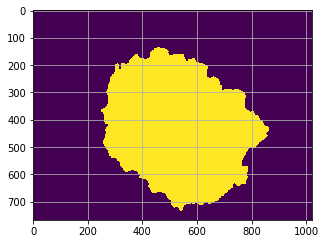

In [5]:
im = open_image(trn_y[2])[:,:,0]
ax = show_img(im)
ax.set_axis_on()
ax.grid()
print(np.unique(im), im.shape)

In [6]:
blob_coords = np.where(im == 1)
blob_ys = blob_coords[0]
blob_xs = blob_coords[1]

ly = min(blob_ys)
uy = max(blob_ys)

lx = min(blob_xs)
ux = max(blob_xs)
print(f'y lower and upper {ly},{uy}')
print(f'x lower and upper {lx},{ux}')

y lower and upper 136,733
x lower and upper 247,864


In [7]:
x = np.arange(9.).reshape(3, 3)
x

array([[0., 1., 2.],
       [3., 4., 5.],
       [6., 7., 8.]])

In [8]:
np.where(x > 5)

(array([2, 2, 2]), array([0, 1, 2]))

In [9]:
b_left = [lx, uy]
b_right= [ux, uy]

t_right = [ux, ly]
t_left = [lx, ly]

h = uy - ly
w = ux - lx

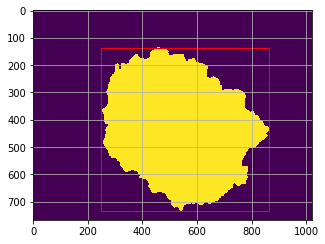

In [10]:
import matplotlib.patches as patches
rect = patches.Rectangle((t_left), w, h, linewidth=1, edgecolor='r', facecolor='none')
ax = show_img(im)
ax.set_axis_on()
ax.grid()
ax.add_patch(rect)


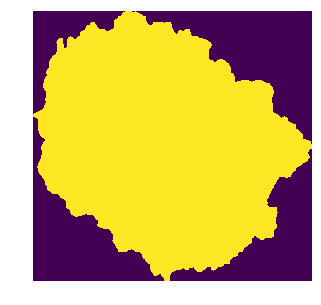

In [17]:
lesion = im[t_left[1]:t_left[1]+h, t_left[0]:t_left[0]+w]
show_img(lesion)

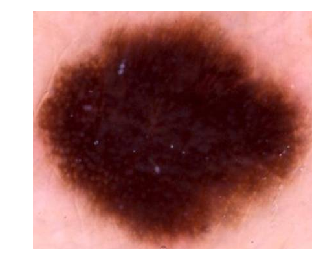

In [6]:
def seg_lesion(im, mask):
    im = im if isinstance(im, np.ndarray) else open_image(im)
    mask = mask if isinstance(mask, np.ndarray) else open_image(mask)
    mask = mask[:,:,0] if mask.ndim > 2 else mask
    blob_coords = np.where(mask == 1)   
    blob_ys = blob_coords[0]
    blob_xs = blob_coords[1]

    ly = min(blob_ys)
    uy = max(blob_ys)
    lx = min(blob_xs)
    ux = max(blob_xs)
    
    t_left = [lx, ly]
    h = uy - ly
    w = ux - lx
    
    return im[t_left[1]:t_left[1]+h, t_left[0]:t_left[0]+w]

segs = seg_lesion(trn_x[200], trn_y[200])
show_img(segs)

In [26]:
trn_fns = []
for count, (im, mask) in enumerate(zip(trn_x, trn_y)):
    if count % 100 == 0:
        print('Saved {}/{} images'.format(count, len(trn_x)))
    im = str(im)
    par_dir = str(os.path.dirname(im))
    n_par_dir = par_dir + '_lesion_seg'
    nname = im.replace(par_dir, n_par_dir)
    if not os.path.isdir(os.path.dirname(nname)): os.mkdir(os.path.dirname(nname))
    trn_fns.append(nname)
    if os.path.exists(nname): continue
    seg_im = seg_lesion(im, mask)
    scipy.misc.imsave(nname, seg_im)

Saved 0/3300 images
Saved 100/3300 images
Saved 200/3300 images
Saved 300/3300 images
Saved 400/3300 images
Saved 500/3300 images
Saved 600/3300 images
Saved 700/3300 images
Saved 800/3300 images
Saved 900/3300 images
Saved 1000/3300 images
Saved 1100/3300 images
Saved 1200/3300 images
Saved 1300/3300 images
Saved 1400/3300 images
Saved 1500/3300 images
Saved 1600/3300 images
Saved 1700/3300 images
Saved 1800/3300 images
Saved 1900/3300 images
Saved 2000/3300 images
Saved 2100/3300 images
Saved 2200/3300 images
Saved 2300/3300 images
Saved 2400/3300 images
Saved 2500/3300 images
Saved 2600/3300 images
Saved 2700/3300 images
Saved 2800/3300 images
Saved 2900/3300 images
Saved 3000/3300 images
Saved 3100/3300 images
Saved 3200/3300 images


In [27]:
tst_fns = []
for count, (im, mask) in enumerate(zip(test_x, test_y)):
    if count % 100 == 0:
        print('Saved {}/{} images'.format(count, len(test_x)))
    im = str(im)
    par_dir = str(os.path.dirname(im))
    n_par_dir = par_dir + '_lesion_seg'
    nname = im.replace(par_dir, n_par_dir)
    if not os.path.isdir(os.path.dirname(nname)): os.mkdir(os.path.dirname(nname))
    tst_fns.append(nname)
    if os.path.exists(nname): continue
    seg_im = seg_lesion(im, mask)
    scipy.misc.imsave(nname, seg_im)

Saved 0/600 images
Saved 100/600 images
Saved 200/600 images
Saved 300/600 images
Saved 400/600 images
Saved 500/600 images


In [28]:
val_fns = []
for count, (im, mask) in enumerate(zip(val_x, val_y)):
    if count % 100 == 0:
        print('Saved {}/{} images'.format(count, len(val_x)))
    im = str(im)
    par_dir = str(os.path.dirname(im))
    n_par_dir = par_dir + '_lesion_seg'
    nname = im.replace(par_dir, n_par_dir)
    if not os.path.isdir(os.path.dirname(nname)): os.mkdir(os.path.dirname(nname))
    val_fns.append(nname)
    if os.path.exists(nname): continue
    seg_im = seg_lesion(im, mask)
    scipy.misc.imsave(nname, seg_im)

Saved 0/150 images


/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


Saved 100/150 images


In [31]:
len(trn_fns), len(val_fns), len(tst_fns)

(3300, 150, 600)

### Create CSVs

In [35]:
sk_path = Path('/home/sean/hpc-home/skin_cancer/')
dep = sk_path / 'isic_archive/recod_titans_sub/data/deploy2017.txt'
rec = pd.read_csv(dep)
rec.columns = [ss.strip() for ss in rec.columns]
rec = rec.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
print(rec.head())
def getds(data): return rec.loc[rec['dataset'] == data][['image', 'melanoma', 'keratosis']]
def add_class_col(df, cats=['melanoma', 'keratosis']):
    df['classes'] = np.nan
    for c in cats:
        print('adding %s to class' % c)
        df['classes'].iloc[df[c].nonzero()[0]] = c
    df['classes'].fillna('nevus', inplace=True)
    df.head()
    return df

def vis_classes(df, col='classes'):
    df[col].value_counts().plot(kind='barh')
    print(df[col].value_counts())
    
def check_paths(iterable): return all([os.path.exists(PATH /i) for i in list(iterable)])

    image      case type age  has_age     sex  has_sex  melanoma  keratosis  \
0  adl379  4A378379    d  45        1  female        1         0          0   
1  ael455  4A454455    d  57        1    male        1         0          0   
2  ael469  4A468469    d  68        1  female        1         0          0   
3  ael502  4A501502    d  40        1  female        1         0          0   
4  ael505  4A505505    d  65        1    male        1         0          0   

   schedule  weight dataset  
0         2       3   atlas  
1         2       3   atlas  
2         1       3   atlas  
3         2       3   atlas  
4         2       3   atlas  


#### Load ISIC 17 Training Data

In [45]:
ict = getds('challenge')
ict.index = 'ISIC/ISIC-2017_Training_Data_lesion_seg/' + ict['image'] + '.jpg'
ict = ict[['melanoma', 'keratosis']]
ict = add_class_col(ict)
ict.head()

adding melanoma to class
adding keratosis to class


/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,melanoma,keratosis,classes
image,,,
ISIC/ISIC-2017_Training_Data_lesion_seg/ISIC_0000000.jpg,0,0,nevus
ISIC/ISIC-2017_Training_Data_lesion_seg/ISIC_0000001.jpg,0,0,nevus
ISIC/ISIC-2017_Training_Data_lesion_seg/ISIC_0000002.jpg,1,0,melanoma
ISIC/ISIC-2017_Training_Data_lesion_seg/ISIC_0000003.jpg,0,0,nevus
ISIC/ISIC-2017_Training_Data_lesion_seg/ISIC_0000004.jpg,1,0,melanoma


In [51]:
check_paths(ict.index)

True

#### Load Dermofit Data

In [49]:
ddf = getds('dermofit')
ddf = add_class_col(ddf)
ddf_t = pd.read_csv(PATH / 'dermofit/train.csv')
ddf_t.columns = ['image', 'class']

ddf_ids = ddf['image'].tolist()
ddf_pths = ddf_t['image'].tolist()
# [os.path.basename(ss) for ss in ddf_pths] == ddf_ids
new_ddfp = []
for pp in ddf_pths:
    d, b = os.path.split(pp)
    d += '_lesion_seg'
    new_ddfp.append(os.path.join(d, b))
dermfit_image_id = ['dermofit/' + i + '.png' for i in new_ddfp]
print(all([(PATH / i).exists() for i in dermfit_image_id]))
ddf.index = dermfit_image_id
ddf.head()

adding melanoma to class
adding keratosis to class


/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


True


,image,melanoma,keratosis,classes
dermofit/ALLBCC/D204a_lesion_seg/D204a.png,D204a,0,0,nevus
dermofit/ALLSCC/D222_lesion_seg/D222.png,D222,0,0,nevus
dermofit/ALLML/D226b_lesion_seg/D226b.png,D226b,0,0,nevus
dermofit/ALLML/D226c_lesion_seg/D226c.png,D226c,0,0,nevus
dermofit/ALLML/D227_lesion_seg/D227.png,D227,0,0,nevus


In [50]:
check_paths(ddf.index)

True

#### Load ISIC Validation Data

In [60]:
icv = pd.read_csv(PATH / 'val_isic17.csv')
icv.columns = ['image', 'class']

icv['melanoma'] = (icv['class'] == 'MEL').astype(int)
icv['keratosis'] = (icv['class'] == 'SK').astype(int)
icv.set_index(icv['image'], inplace=True)
new_icvp = []
for pp in list(icv.index):
    d, b = os.path.split(pp)
    d += '_lesion_seg'
    new_icvp.append(os.path.join(d, b))
icv.index = new_icvp

icv.drop(columns=['class', 'image'], inplace=True)
icv = add_class_col(icv)
icv.head()

adding melanoma to class
adding keratosis to class


/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,melanoma,keratosis,classes
ISIC/ISIC-2017_Validation_Data_lesion_seg/ISIC_0001769.jpg,0,0,nevus
ISIC/ISIC-2017_Validation_Data_lesion_seg/ISIC_0001852.jpg,0,0,nevus
ISIC/ISIC-2017_Validation_Data_lesion_seg/ISIC_0001871.jpg,0,0,nevus
ISIC/ISIC-2017_Validation_Data_lesion_seg/ISIC_0003462.jpg,0,0,nevus
ISIC/ISIC-2017_Validation_Data_lesion_seg/ISIC_0003539.jpg,0,0,nevus


In [61]:
check_paths(icv.index)

True

#### Load ISIC 17 Test Data

In [68]:
test_all_p = PATH / 'ISIC/test_all_17.csv'
test_df = pd.read_csv(test_all_p)

new_testicv = []
for pp in list(test_df['image_id']):
    d, b = os.path.split(pp)
    d += '_lesion_seg'
    new_testicv.append(os.path.join(d, b))
test_df.index = new_testicv
test_df.drop(columns='image_id', inplace=True)
test_df.head()

,classes
ISIC/ISIC-2017_Test_v2_Data_lesion_seg/ISIC_0012086.jpg,seborrheic_keratosis
ISIC/ISIC-2017_Test_v2_Data_lesion_seg/ISIC_0012092.jpg,nevus
ISIC/ISIC-2017_Test_v2_Data_lesion_seg/ISIC_0012095.jpg,nevus
ISIC/ISIC-2017_Test_v2_Data_lesion_seg/ISIC_0012134.jpg,seborrheic_keratosis
ISIC/ISIC-2017_Test_v2_Data_lesion_seg/ISIC_0012136.jpg,seborrheic_keratosis


In [69]:
check_paths(test_df.index)

True

### Fold into Train datafram and save

In [71]:
train_df_csv = PATH / 'train_seg_isic17_dermo.csv'
train_df = pd.concat([ict['classes'], ddf['classes'], icv['classes']])
train_df.to_csv(train_df_csv)

In [72]:
test_df_csv = PATH / 'ISIC/test_seg_isic17.csv'
test_df.to_csv(test_df_csv)

Min row size 74; Min col size 77


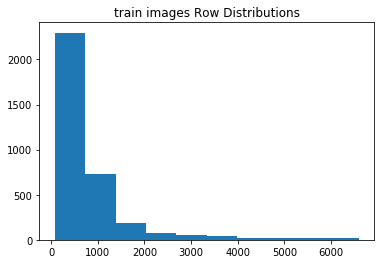

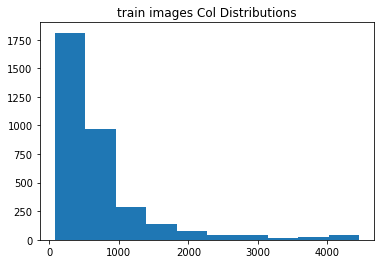

In [78]:
im_hist(list(train_df.index), name='train images', path=str(PATH))

## Load The CSVs as Data Frames

In [6]:
train_csv = PATH / 'train_seg_isic17_dermo.csv'
test_csv = PATH / 'ISIC/test_seg_isic17.csv'
train_csv.exists(), test_csv.exists()

(True, True)

In [13]:
train_seg_df = pd.read_csv(train_csv, header=None, index_col=[0])
test_seg_df = pd.read_csv(test_csv, index_col=[0])
train_seg_df.columns = ['classes']
train_seg_df.head()

,classes
0,
ISIC/ISIC-2017_Training_Data_lesion_seg/ISIC_0000000.jpg,nevus
ISIC/ISIC-2017_Training_Data_lesion_seg/ISIC_0000001.jpg,nevus
ISIC/ISIC-2017_Training_Data_lesion_seg/ISIC_0000002.jpg,melanoma
ISIC/ISIC-2017_Training_Data_lesion_seg/ISIC_0000003.jpg,nevus
ISIC/ISIC-2017_Training_Data_lesion_seg/ISIC_0000004.jpg,melanoma


In [21]:
train_seg_df['classes'].value_counts()

nevus        2417
keratosis     553
melanoma      480
Name: classes, dtype: int64

In [11]:
test_seg_df.head()

,classes
ISIC/ISIC-2017_Test_v2_Data_lesion_seg/ISIC_0012086.jpg,seborrheic_keratosis
ISIC/ISIC-2017_Test_v2_Data_lesion_seg/ISIC_0012092.jpg,nevus
ISIC/ISIC-2017_Test_v2_Data_lesion_seg/ISIC_0012095.jpg,nevus
ISIC/ISIC-2017_Test_v2_Data_lesion_seg/ISIC_0012134.jpg,seborrheic_keratosis
ISIC/ISIC-2017_Test_v2_Data_lesion_seg/ISIC_0012136.jpg,seborrheic_keratosis


#### SK Split

In [14]:
train_sk_seg_csv = PATH / 'train_SK_seg_isic17_dermo.csv'
test_sk_seg_csv = PATH / 'ISIC/test_SK_seg_isic17_dermo'

In [17]:
def save_bin_df(df, bin_label, dfcsv, class_col='classes'):
    df['bin_class'] = (df[class_col] == bin_label).astype(int)
    df.drop(columns=class_col).to_csv(dfcsv)
    print(df.drop(columns=class_col)['bin_class'].value_counts())

In [22]:
save_bin_df(train_seg_df, 'keratosis', train_sk_seg_csv)

0    2897
1     553
Name: bin_class, dtype: int64


In [23]:
save_bin_df(test_seg_df, 'seborrheic_keratosis', test_sk_seg_csv)

0    510
1     90
Name: bin_class, dtype: int64
